#  IN4050 Mandatory Assignment 1: Traveling Salesman Problem


### Name and Username
Name: Andreas Klæboe  
Username: andrklae

### To run the code:
Simply run the notbook file: Assignment1.ipynb

### Answers
All questions/tasks and my answers and solutions can be found in this file

### Brief explanation:

In this assignment I implemented and compared three different algorithms for solving the Traveling Salesman Problem (TSP):

1. **Exhaustive search**  
   - Explored every possible tour among a subset of cities.  
   - Verified correctness on 6 and 10 cities, and measured runtime growth as the number of cities increased.  
   - Showed how runtime scales factorially (O(n!)), and estimated the infeasible runtime for 24 cities.

2. **Hill climbing**  
   - Implemented a simple local search (2-opt swap) starting from a random permutation.  
   - Repeated the algorithm 20 times to account for stochasticity.  
   - Reported best, worst, mean, and standard deviation of tour lengths for both 10 and 24 cities.  
   - Plotted example tours to visualize solution quality.

3. **Genetic algorithm (GA)**  
   - Implemented with tournament selection, segment crossover, and population sizes of 64, 128, and 256.  
   - Ran 20 independent runs for each configuration.  
   - Collected best, worst, mean, and standard deviation of final tours.  
   - Compared average best fitness per generation across runs, and visualized the results for the three population sizes.  
   - Plotted example optimized tours for each population size.  
   - Compared GA performance and runtime with exhaustive search for both 10 and 24 cities, and counted the number of tours inspected.

Overall, the results show that exhaustive search guarantees the optimal solution but is only feasible for small subsets. The hill climber quickly finds reasonable tours but may get stuck in local optima. The genetic algorithm performs better on larger instances, producing near-optimal solutions in a fraction of the time required by exhaustive search, and scales well to all 24 cities.

## Helper code for visualizing solutions

Here follows some helper code that you can use to visualize the plans you generate. These visualizations can **help you check if you are making sensible tours or not**. The optimization algoritms below should hopefully find relatively nice looking tours, but perhaps with a few visible inefficiencies.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(57)
#Map of Europe
europe_map = plt.imread('map.png')

#Lists of city coordinates
city_coords = {
    "Barcelona": [2.154007, 41.390205], "Belgrade": [20.46, 44.79], "Berlin": [13.40, 52.52], 
    "Brussels": [4.35, 50.85], "Bucharest": [26.10, 44.44], "Budapest": [19.04, 47.50],
    "Copenhagen": [12.57, 55.68], "Dublin": [-6.27, 53.35], "Hamburg": [9.99, 53.55], 
    "Istanbul": [28.98, 41.02], "Kyiv": [30.52, 50.45], "London": [-0.12, 51.51], 
    "Madrid": [-3.70, 40.42], "Milan": [9.19, 45.46], "Moscow": [37.62, 55.75],
    "Munich": [11.58, 48.14], "Paris": [2.35, 48.86], "Prague": [14.42, 50.07],
    "Rome": [12.50, 41.90], "Saint Petersburg": [30.31, 59.94], "Sofia": [23.32, 42.70],
    "Stockholm": [18.06, 60.33], "Vienna": [16.36, 48.21], "Warsaw": [21.02, 52.24]}


In [23]:
#Helper code for plotting plans
#First, visualizing the cities.
import csv
with open("european_cities.csv", "r") as f:
    data = list(csv.reader(f, delimiter=';'))
    cities = data[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

# Map (long, lat) to (x, y) for plotting
for city, location in city_coords.items():
    x, y = (location[0], location[1])
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, city, fontsize=12)


In [24]:
#A method you can use to plot your plan on the map.
def plot_plan(city_order):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

    # Map (long, lat) to (x, y) for plotting
    for index in range(len(city_order) - 1):
        current_city_coords = city_coords[city_order[index]]
        next_city_coords = city_coords[city_order[index+1]]
        x, y = current_city_coords[0], current_city_coords[1]
        #Plotting a line to the next city
        next_x, next_y = next_city_coords[0], next_city_coords[1]
        plt.plot([x, next_x], [y, next_y])

        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, index, fontsize=12)
    #Finally, plotting from last to first city
    first_city_coords = city_coords[city_order[0]]
    first_x, first_y = first_city_coords[0], first_city_coords[1]
    plt.plot([next_x, first_x], [next_y, first_y])
    #Plotting a marker and index for the final city
    plt.plot(next_x, next_y, 'ok', markersize=5)
    plt.text(next_x, next_y, index+1, fontsize=12)
    plt.show()


## Exhaustive Search
First, try to solve the problem by inspecting every possible tour. Start by writing a program to find the shortest
tour among a subset of the cities (say, **6** of them). Measure the amount of time your program takes. Incrementally
add more cities and observe how the time increases. Plot the shortest tours you found using the plot_plan method above, for 6 and 10 cities.

**Note:** To get distances between cities, use the dictionary `data` created by reading the file `european_cities.csv`. *Do not* calculate distances based on the coordinates. The actual distances do not only depend on the differences in the coordinates, but also of the curvature of the earth. The distances available in `data` are corrected for this, and contain the actual true distances.

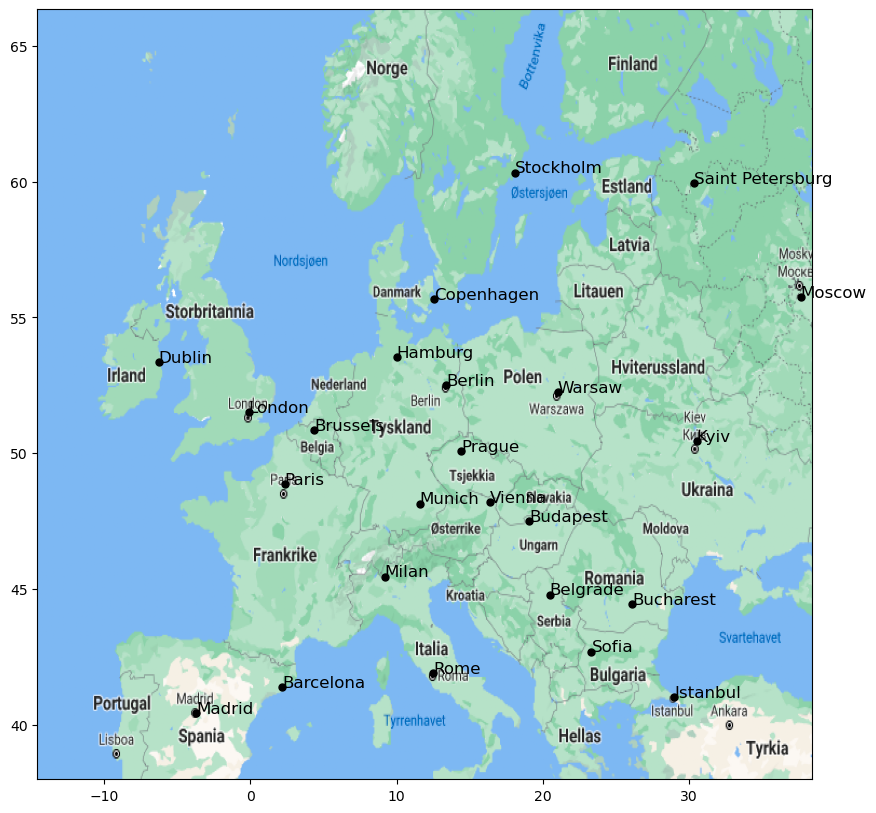

Path with 6 random cities:
Prague -> Warsaw -> Dublin -> Barcelona -> Rome -> Munich
Distance: 5662.589999999999


Path with 10 random cities:
Barcelona -> Rome -> Belgrade -> Budapest -> Munich -> Prague -> Warsaw -> Stockholm -> Hamburg -> Dublin
Distance: 7433.869999999999


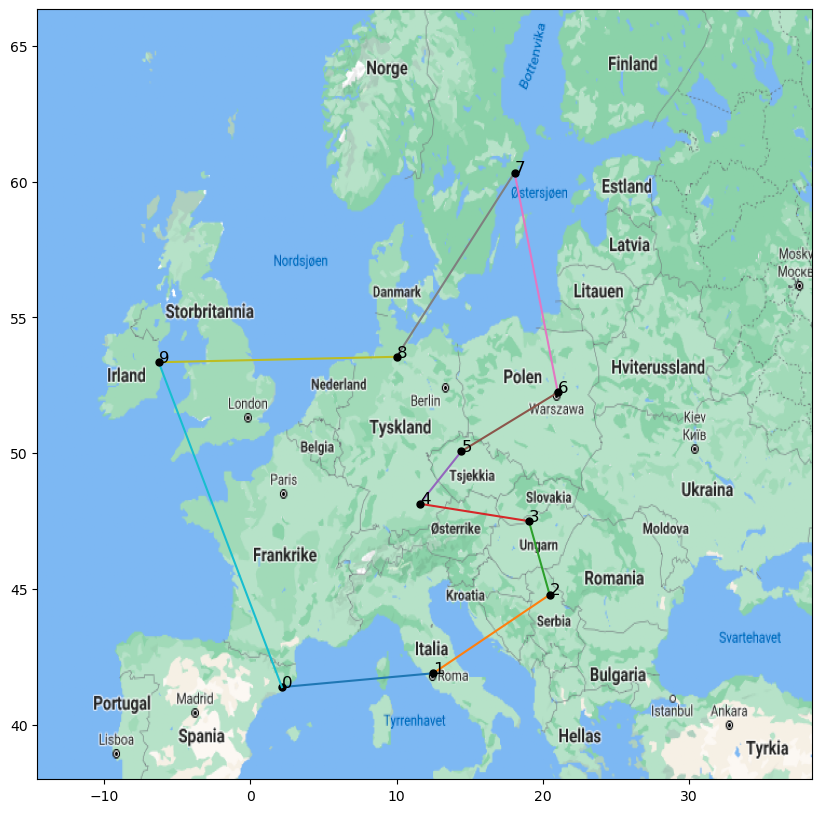

In [25]:
import random
import time
# Implement the algorithm here

# matrix of distances between cities
dist_matrix = [list(map(float, row)) for row in data[1:]] 

# map cities to their index
city_dict = {}
for i in range(len(cities)):
    city_dict[i] = cities[i]

# function to calculate the total distance of a given permutation
def calc_dist(permutation):
    if len(permutation) < 2:
        return 0.0
    total = 0.0
    for i in range(len(permutation) - 1):
        total += dist_matrix[permutation[i]][permutation[i+1]]
    
    # add return to start (full circle)
    total += dist_matrix[permutation[-1]][permutation[0]]
    return total

# exhaustive search on a given subset of citites
def exh_search(cities_included, path=None, shortest=None):
    if path is None:
        path = []

    if not cities_included:
        distance = calc_dist(path)
        if shortest is None or distance < shortest[1]:
            shortest = [path, distance]
        return shortest

    for i in range(len(cities_included)):
        candidate = exh_search(
            cities_included[:i] + cities_included[i+1:],
            path + [cities_included[i]],
            shortest
        )
        if shortest is None or candidate[1] < shortest[1]:
            shortest = candidate
    return shortest

# create random subsets of cities
indexes = list(range(len(cities)))
subset10 = random.sample(indexes, 10)
subset6 = subset10[:6]

# map exh_search times to size of list
exh_dict = {}
for i in range(5):
    i = i + 6
    subset = subset10[:i]
    
    start = time.time()
    exh_search(subset)
    end = time.time()

    elapsed = end - start
    exh_dict[i] = elapsed

# bar chart for times
plt.figure(figsize=(8,5))
bars = plt.bar(exh_dict.keys(), exh_dict.values())
bars = plt.bar(exh_dict.keys(), exh_dict.values())
plt.xlabel("Subset size (number of cities)")
plt.ylabel("Elapsed time (seconds)")
plt.title("Exhaustive search runtime by subset size")

# add labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.4f}s",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

shortest6 = exh_search(subset6)
path6, distance6 = shortest6[0], shortest6[1]
city_path6 = [city_dict[i] for i in path6]

shortest10 = exh_search(subset10)
path10, distance10 = shortest10[0], shortest10[1]
city_path10 = [city_dict[i] for i in path10]

print("Path with 6 random cities:")
print(" -> ".join(city_path6))
print("Distance:", distance6)
plot_plan(city_path6)

print("Path with 10 random cities:")
print(" -> ".join(city_path10))
print("Distance:", distance10)

plot_plan(city_path10)

What is the shortest tour (i.e., the actual sequence of cities, and its length) among the first 10 cities (that is,
the cities starting with B,C,D,H and I)? How long did your program take to find it? Calculate an approximation of how long it would take to perform exhaustive search on all 24 cities?

In [26]:
# Answer
import math

first10 = list(range(10))
city_names = cities[:10]

start = time.time()
exh_search_result = exh_search(first10)
end = time.time()
exh_elapsed = end - start

path = exh_search_result[0]
city_path = [city_dict[i] for i in path]
distance = exh_search_result[1]

print("Shortest tour among the first 10 cities:")
print(" -> ".join(city_path))
print("Distance:", distance)
print("Time spent:", exh_elapsed, "seconds")
print()

runs = math.factorial(10)
time_per_run = exh_elapsed / runs
runs_24 = time_per_run * math.factorial(24)

print("Calculation of all 24 cities: ")
print("exh_search is in O(n!)")
print(f"Elapsed time for 10 cities was ~ {exh_elapsed:.2f}s meaning each run on average took {exh_elapsed:.2f} / 10! ~ {time_per_run:.2e}s")
print(f"That means a run of 24 cities would take {time_per_run:.2e}s x 24! = {runs_24:.2e}s")
print(f"That is equal to ~ {runs_24 / 60 / 60 / 24 / 365 / 1_000_000_000:.1f} billion years")


Shortest tour among the first 10 cities:
Copenhagen -> Hamburg -> Brussels -> Dublin -> Barcelona -> Belgrade -> Istanbul -> Bucharest -> Budapest -> Berlin
Distance: 7486.309999999999
Time spent: 4.12452507019043 seconds

Calculation of all 24 cities: 
exh_search is in O(n!)
Elapsed time for 10 cities was ~ 4.12s meaning each run on average took 4.12 / 10! ~ 1.14e-06s
That means a run of 24 cities would take 1.14e-06s x 24! = 7.05e+17s
That is equal to ~ 22.4 billion years


## Hill Climbing
Then, write a simple hill climber to solve the TSP. How well does the hill climber perform, compared to the result from the exhaustive search for the first **10 cities**? Since you are dealing with a stochastic algorithm, you
should run the algorithm several times to measure its performance. Report the length of the tour of the best,
worst and mean of 20 runs (with random starting tours), as well as the standard deviation of the runs, both with the **10 first cities**, and with all **24 cities**. Plot one of the the plans from the 20 runs for both 10 cities and 24 cities (you can use plot_plan). 

results from the firstr 10 cities:
Best: 7486.31
Worst: 8407.18
Mean: 7758.28
Standard deviation: 337.69
Compared to exhaustive search:
~ 43685.6 times faster on average, and
Average distance were 3.63% longer

results from all 24 cities:
Best: 12744.91
Worst: 16702.96
Mean: 14202.45
Standard deviation: 894.13


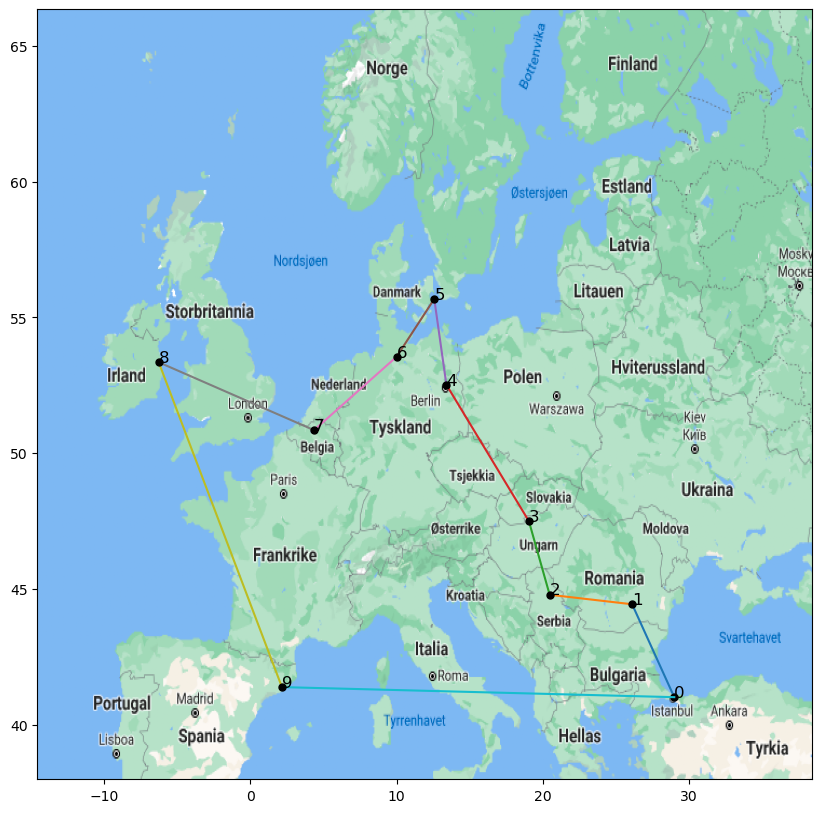

In [27]:
# Implement the algorithm here
def swap(arr, i, j):
    out = arr[:]
    out[i], out[j] = out[j], out[i]
    return out

def hill_climb(permutation):
    current = permutation[:]
    # start from a random permutation
    random.shuffle(current)
    current_dist = calc_dist(current)

    improved = True
    while improved:
        improved = False
        # 2-opt swap, stop at first improvement
        for i in range(len(current)):
            for j in range(i + 1, len(current)):
                candidate = swap(current, i, j)
                cand_dist = calc_dist(candidate)
                if cand_dist < current_dist:
                    current, current_dist = candidate, cand_dist
                    improved = True
                    break  
            if improved:
                break
    return [current, current_dist]

hill_climb_results_10 = {}

for i in range(20):
    start = time.time()
    result = hill_climb(first10)
    end = time.time()
    elapsed = end - start

    tour, dist = result[0], result[1]
    tour = [city_dict[i] for i in tour]

    hill_climb_results_10[i+1] = {
        "tour": tour,
        "distance": dist,
        "elapsed": elapsed
    }

distances = np.array([run["distance"] for run in hill_climb_results_10.values()])
times = np.array([run["elapsed"] for run in hill_climb_results_10.values()])

best = np.min(distances)
worst = np.max(distances)
mean_dist = np.mean(distances)
mean_time = np.mean(times)
stddev = np.std(distances, ddof=1)

print("results from the firstr 10 cities:")
print(f"Best: {best:.2f}")
print(f"Worst: {worst:.2f}")
print(f"Mean: {mean_dist:.2f}")
print(f"Standard deviation: {stddev:.2f}")
print("Compared to exhaustive search:")
print(f"~ {exh_elapsed / mean_time:.1f} times faster on average, and")
exh_dist = exh_search(first10)[1]
diff_percent = (mean_dist - exh_dist) / exh_dist * 100
print(f"Average distance were {diff_percent:.2f}% longer")

hill_climb_results_all = {}

for i in range(20):
    start = time.time()
    result = hill_climb(list(range(len(cities))))
    end = time.time()
    elapsed = end - start

    tour, dist = result[0], result[1]
    tour = [city_dict[i] for i in tour]

    hill_climb_results_all[i+1] = {
        "tour": tour,
        "distance": dist,
        "elapsed": elapsed
    }

distances = np.array([run["distance"] for run in hill_climb_results_all.values()])

best = np.min(distances)
worst = np.max(distances)
mean = np.mean(distances)
stddev = np.std(distances, ddof=1)

print()
print("results from all 24 cities:")
print(f"Best: {best:.2f}")
print(f"Worst: {worst:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {stddev:.2f}")

hc_10 = hill_climb(first10)
hc_24 = hill_climb(list(range(len(cities))))
plan_10 = [city_dict[i] for i in hc_10[0]]
plan_24 = [city_dict[i] for i in hc_24[0]]
plot_plan(plan_10)
plot_plan(plan_24)



## Genetic Algorithm
Next, write a genetic algorithm (GA) to solve the problem. Choose mutation and crossover operators that are appropriate for the problem (see chapter 4.5 of the Eiben and Smith textbook). Choose three different values for the population size. Define and tune other parameters yourself and make assumptions as necessary (and report them, of course).

For all three variants: As with the hill climber, report best, worst, mean and standard deviation of tour length out of 20 runs of the algorithm (of the best individual of last generation). Also, find and plot the average fitness of the best fit individual in each generation (average across runs), and include a figure with all three curves in the same plot in the report. This means that the x-axis should be the generations over time and the y-axis should be the average (over the 20-runs) fitness of the best gene in that generation. Conclude which is best in terms of tour length and number of generations of evolution time.

Finally, plot an example optimized tour (the best of the final generation) for the three different population sizes, using the plot_plan method.

Population size: 64
best: 13903.82
worst: 17075.05
mean: 15742.16
standard deviation: 930.50

Population size: 128
best: 12808.35
worst: 15392.46
mean: 13633.18
standard deviation: 566.92

Population size: 256
best: 12514.02
worst: 20237.88
mean: 13490.15
standard deviation: 794.54



population size: 64


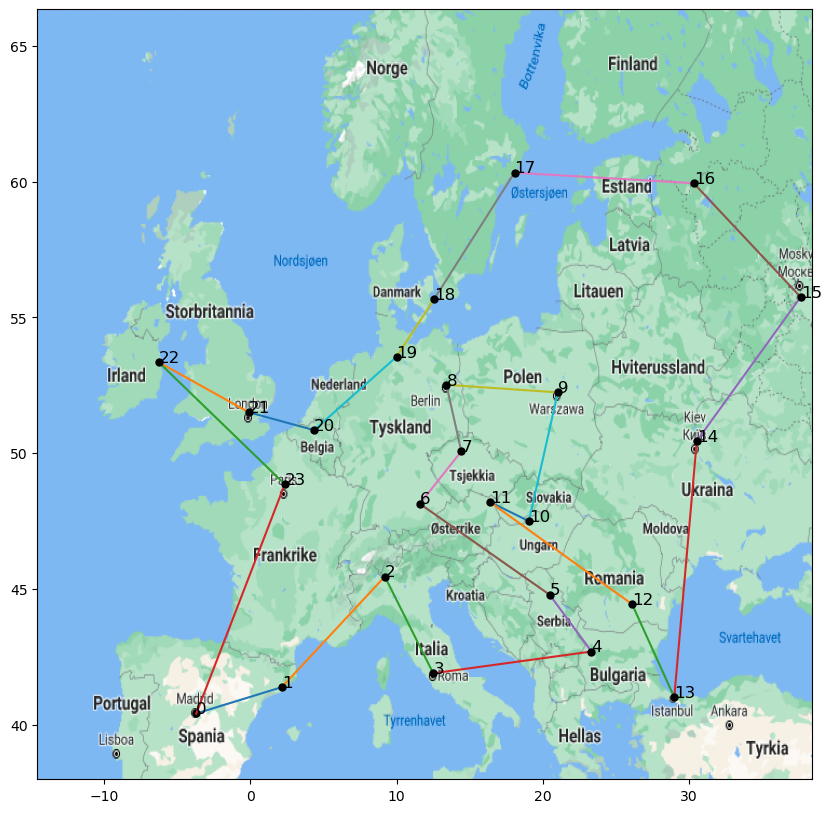

population size: 128


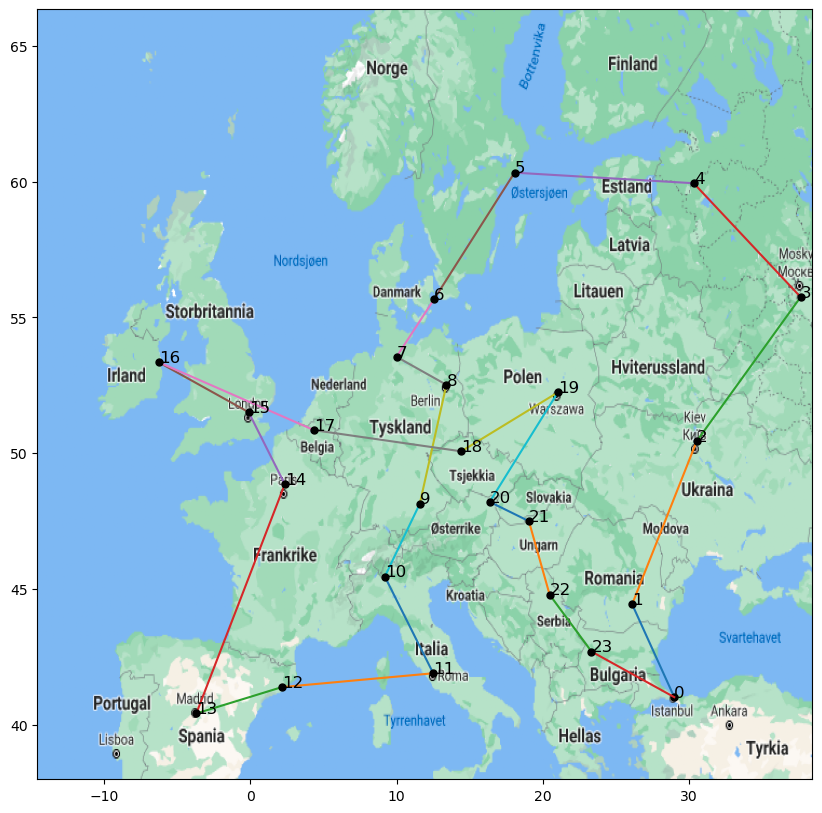

population size: 256


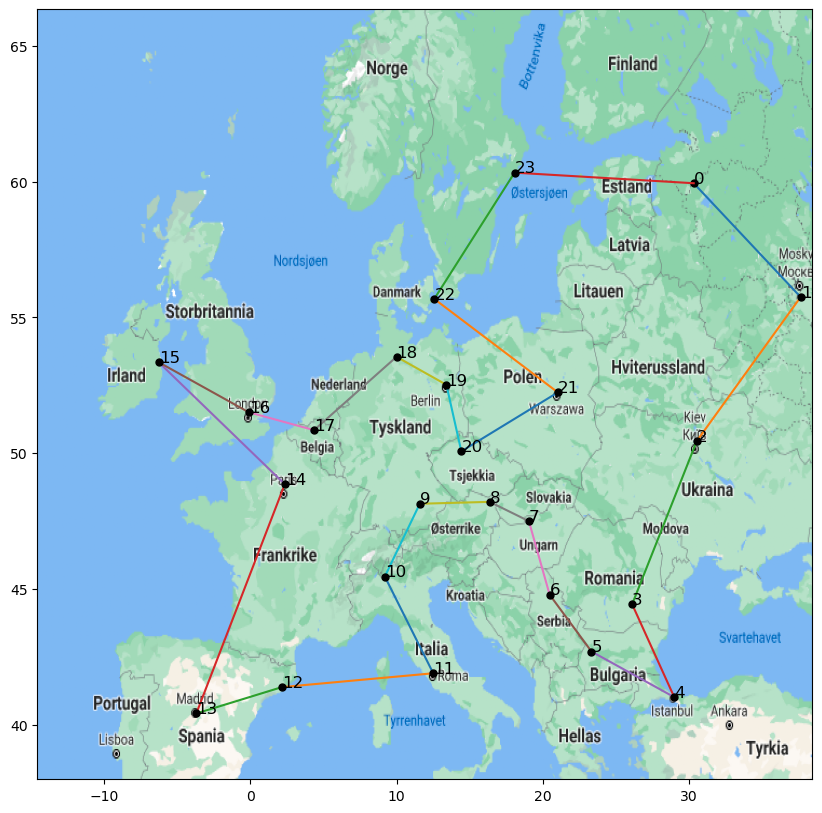

In [28]:
# Implement the algorithm here

# Generates random paths
def generate_random_population(destinations, population_size):
    population = []
    for _ in range(population_size):
        random_order = destinations[:]
        random.shuffle(random_order)
        population.append(random_order)
    
    return population

# will put two and two permutations ups against eachother and pick a winner. population size will half
def choose_survivors(population):
    survivors = []
    competitors = population[:]
    random.shuffle(competitors)
    midway = len(competitors) // 2

    for i in range(midway):
        left = competitors[i]
        right = competitors[i + midway]

        if calc_dist(left) < calc_dist(right): survivors.append(left)
        else: survivors.append(right)

    ## appends the last item if population was odd numbered
    if len(competitors) % 2 == 1: survivors.append(competitors[-1])
        
    return survivors

# copies parent2, selects a random segment from parent1 and inserts it
def create_offspring(parent1, parent2):
    offspring = []
    segment_start = random.randint(0, len(parent1) - 1)
    segment_end = random.randint(segment_start, len(parent1))

    segment1 = parent1[segment_start:segment_end]
    segment2 = list([item for item in parent2 if item not in segment1]) # copies all items from parent 2 that does not exist in segment1

    for i in range(0, len(parent1)):
        if segment_start <= i < segment_end:
            offspring.append(segment1.pop(0))
        else:
            offspring.append(segment2.pop(0))

    return offspring

def generate_offsprings(survivors):
    offsprings = []
    midway = midway = len(survivors) // 2

    for i in range(midway):
        mom = survivors[i]
        dad = survivors[i + midway]
        
        # generate offsprings twice to double population
        # create_offspring is stochastic, so the offsprings are unlikely to be identical
        for _ in range(2):
            kid1 = create_offspring(mom, dad)
            kid2 = create_offspring(dad, mom)
            offsprings += [kid1, kid2]
    return offsprings


# I chose these population sizes because theyre 2^x, meaning 
# they can always be halved without messing up the population size
pop_sizes = [64, 128, 256]
gens = 100
results = {} # will be {pop_size: [runs[generations[distances]]]}
destinations = list(range(len(cities)))

best_paths = {} # will be {pop_size : best path found}
for size in pop_sizes:
    runs = []
    best, length = None, None

    for _ in range(20):
        gen_results = [] # List of each generation. index = generation number
        pop = generate_random_population(destinations, size)
        gen_results.append([calc_dist(tour) for tour in pop]) # gen 0

        for i in range(gens):
            pop = choose_survivors(pop)
            pop = generate_offsprings(pop)
            gen_results.append([calc_dist(tour) for tour in pop])
            
            # checks if a path generated is the best so far of its pop size
            for path in pop:
                dist = calc_dist(path)
                if length is None or length > dist:
                    best, length = path, dist
        
        runs.append(gen_results)

    results[size] = runs
    best_paths[size] = [city_dict[i] for i in best]

# results for each pop size
for size in pop_sizes:
    print("Population size:", size)
    
    last_gens = []
    for run in results[size]:
        last = run[-1]
        last_gens += (last)

    best = min(last_gens)
    worst = max(last_gens)
    mean = np.mean(last_gens)
    stdev = np.std(last_gens) if len(last_gens) > 1 else 0.0

    print(f"best: {best:.2f}")
    print(f"worst: {worst:.2f}")
    print(f"mean: {mean:.2f}")
    print(f"standard deviation: {stdev:.2f}")
    print()
            
# mean of each pop size by generation
results_per_size = {}
for size in pop_sizes:
    # number of generations per run
    n_gens = len(results[size][0])  

    # pre-fill with empty lists
    gens = [[] for _ in range(n_gens)]  

    # collect best per generation across all runs
    for run in results[size]:
        for gen_i, gen in enumerate(run):
            # if gen is a dict with "best"
            gens[gen_i].append(min(gen))

    # average across runs for each generation
    avg_per_gen = [np.mean(gen) for gen in gens]
    results_per_size[size] = avg_per_gen

plt.figure(figsize=(8,5))

for size, avg_curve in results_per_size.items():
    plt.plot(range(len(avg_curve)), avg_curve, label=f"Pop {size}")

plt.xlabel("Generation")
plt.ylabel("Average best tour length")
plt.title("GA performance across population sizes")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# plots the tours on a map
for size in pop_sizes:
    print("population size:", size)
    plot_plan(best_paths[size])



Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close? 

For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search? 

How many tours were inspected by your GA as compared to by the exhaustive search?

In [29]:
# Answer
# im assuming that im not supposed to run the GA 20 times for this part

start = time.time()
exh_10 = exh_search(list(range(10)))
end = time.time()

exh_10_time = end - start
dist_exh = exh_10[1]

GA_10 = []

start = time.time()
pop = generate_random_population(list(range(10)), 256) # population size of 256
for i in range(100): # 100 gens
    pop = choose_survivors(pop)
    pop = generate_offsprings(pop)
    
    # checks if the path generated is the best so far
    for path in pop:
        dist = calc_dist(path)
        if length is None or length > dist:
            GA_10 = path
end = time.time()

GA_10_time = end - start
dist_GA = calc_dist(GA_10)

print("for the first 10 cities: ")
print(f"Exhaustive search found a distance of: {dist_exh:.4f}")
print(f"My GA found a distance of: {dist_GA:.4f}")
print(f"GA spent {GA_10_time / exh_10_time * 100:.2f}% of the time Exhaustive search did")
print(f"That is {exh_10_time / GA_10_time:.2f} times faster")
print(
    f"GA inspected {256 * 100:,} tours, "
    f"while Exhaustive search inspected {math.factorial(10):,} tours"
)
print()

print("For all 24 cities:")

start = time.time()
pop = generate_random_population(list(range(24)), 256)
for i in range(100): # 100 gens
    pop = choose_survivors(pop)
    pop = generate_offsprings(pop)
end = time.time()

GA_24_time = end - start

print(f"exhaustive search would spend {runs_24 / 60 / 60 / 24 / 365 / 1_000_000_000:.1f} billion years")
print(f"while GA spent {GA_24_time:.4f} seconds")



for the first 10 cities: 
Exhaustive search found a distance of: 7486.3100
My GA found a distance of: 7486.3100
GA spent 1.66% of the time Exhaustive search did
That is 60.18 times faster
GA inspected 25,600 tours, while Exhaustive search inspected 3,628,800 tours

For all 24 cities:
exhaustive search would spend 22.4 billion years
while GA spent 0.0999 seconds
